In [1]:
!pip install tensorflow==2.16.1

Tensorflow kütüphanesinin kurulumu yapıldıktan sonra verinin sınıfları görselleştirildi.


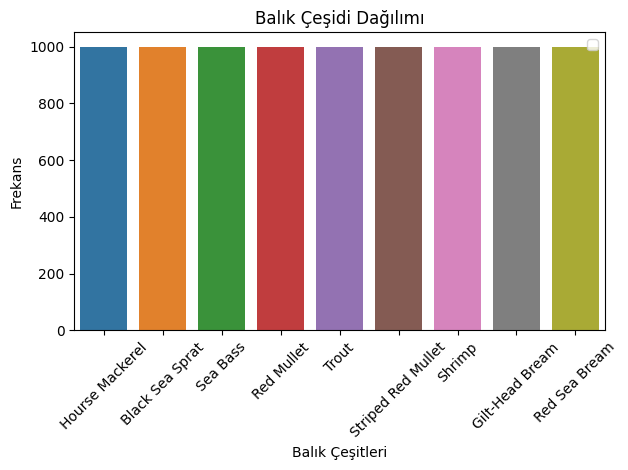

In [2]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import tensorflow as tf
from tensorflow import keras as ks
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

label = []
path = []

fish_dir = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'

for dir_name, _, filenames in os.walk(fish_dir):
    for filename in filenames:
        if os.path.splitext(filename)[-1] == '.png':  # Eğer dosya .png uzantılıysa
            if dir_name.split()[-1] != 'GT':  # Eğer klasör adı 'GT' değilse
                label.append(os.path.split(dir_name)[-1])  # Klasör adını (etiket) ekle
                path.append(os.path.join(dir_name, filename))  # Dosya yolunu ekle

data = pd.DataFrame(columns=['path', 'label'])  # 'path' ve 'label' sütunlarıyla boş DataFrame oluştur
data['path'] = path  # Dosya yollarını ekle
data['label'] = label  # Etiketleri ekle
sns.countplot(x="label",data=data)
plt.xticks(rotation=45)
plt.title("Balık Çeşidi Dağılımı")
plt.xlabel("Balık Çeşitleri")
plt.ylabel("Frekans")
plt.tight_layout() 
plt.legend()






Görüntü olarak bulunan veri, 32'lik bach'lerle 128 * 128 piksel boyutlarında çekilerek çok boyutlu vektöre dönüştürüldü. Çok boyutlu vektördeki sayısal değerler 1-255 arasındaki değerleri içerdiği için normalizasyon amacıyla veri 0-1 arasına rescale edildi. Ayrıca veri etiketleri yani balık çeşidi/sınıfı label olarak çekildi. Bu da "class_mode = categorical" ile one-hot-encode edilmiş olarak yüklendi.

In [3]:
# Veri yükleme ve ön işleme fonksiyonu
def load_and_preprocess_data(data_path, img_height, img_width):
    
    datagen = ImageDataGenerator(rescale=1./255)
    
    generator = datagen.flow_from_directory(
        data_path,
        target_size=(img_height, img_width),
        batch_size=32,
        class_mode='categorical',
        shuffle=True
    )
    
    images, labels = [], []
    for i in range(len(generator)):
        batch = next(generator)
        images.append(batch[0])
        labels.append(batch[1])
        if (i + 1) * 32 >= generator.samples:
            break
 
    
    return np.concatenate(images), np.concatenate(labels)

IMG_HEIGHT, IMG_WIDTH = 128, 128
x, y = load_and_preprocess_data(fish_dir, IMG_HEIGHT, IMG_WIDTH)


Found 18000 images belonging to 9 classes.


Veri seti eğitim,doğrulama ve test olmak üzere ayrıldı. Verinin 70% si eğitim setiyken, geriye kalan kısım her biri 15% olarak validasyon ve test olarak ayrıldı. Ardından boyutlar kontrol edildi.

In [4]:
#train,validation,test split of data
x_train,x_temp,y_train,y_temp = train_test_split(x,y,test_size=0.3)
x_val,x_test,y_val,y_test = train_test_split(x_temp,y_temp,test_size=0.5)
print(f"Train seti uzunluk {len(x_train)}")#18000*0.7=12600
print(f"Validasyon seti uzunluk {len(x_val)}")#18000*0.3*0.5=2700
print(f"Test seti uzunluk {len(x_test)}")#2700
print(f"Train seti boyutu: {x_train.shape}")

Train seti uzunluk 12600
Validasyon seti uzunluk 2700
Test seti uzunluk 2700
Train seti boyutu: (12600, 128, 128, 3)


Bu kısımda ANN modeli kurularak eğitildi.
Öncelikle dense layers tarafından işlenebilmesi için çok boyutlu vektör, Flatten ile iki boyutlu olarak input layer'a alındı. Ardından 4 tane hidden layer tanımlandı. Burada deneme-yanılma ile keşfedilerek nöron sayısı 2000 olarak tanımlandı. Aktivasyon fonksiyonu olarak ise "relu" kullanıldı. Ayrıca her dense layer/hidden layer da nöronların yarısı rastgele olarak dışarıda bırakıldı. Çıkış katmanı tanımlandı ve çıkışta aktivasyon fonksiyonu olarak çoklu sınıflandırmada iyi çalıştığı için softmax tercih edildi.
Modelin öğrenmesini loss fonksiyonu üzerinden iyileştirecek optimizer tanımlanırken; deneme-yanılma ile karar verilmiş 0.00001 LR ile Adam fonksiyonu, one-hot-encode ve çoklu sınıflandırma ile kullanılabilecek categorical crossentropy kayıp fonksiyonu kullanıldı ve doğrulama ölçüsü olarak accuracy tanımlandı.
Modelde deneme-yanılma ile test edilerek 35 epoch kullanıldı ve yine deneme yanılma ile her seferinde 16'lık setler halinde öğrenmesine karar verildi. Ayrıca 5 epoch boyunca validasyon kayıp fonksiyonunda iyileşme kaydedilmediyse erken durdurma modele tanımlandı.
Eğitim süreci içinde 4000,3000,2000,1000,500 sayılarında nöron tanımlanarak 2000 de karar kılındı. Yine epoch için 20,30,35,50,100,150 denenerek 35 da karar kılındı. Learning Rate için 0.001 den başlanarak bir sıfır eklenerek 0.00001 e kadar denendi ve 0.00001 de karar kılındı. Tüm bunlar farklı kombinasyonlar halinde denendi. Fakat herhangi biri artırıldığında loss ve accuracy de aşırı öğrenme gözlemlendiği için yaklaşık 85% doğruluğu olan bu halinde karar kılındı. Yani train ve validasyon birbirinden uzaklaşmaya başladığı, train ile öğrenme iyileşirken validasyon ile öğrenme kötüleşmeye başladığı noktada karar kılındı.
Bu doğrulamayı yapabilmek için:
* Train-Validation Loss Grafiği ve
* Train-Validation Accuracy Grafiğinden yararlanıldı.
Son olarak modeli görmediği veri setinde değerlendirmek için test seti üzerinde model koşuldu ve modelin 80-85 aralığında doğruluk gösterdiği anlaşıldı. Bir de veri seti içinden rastgele seçilen bir nokta için doğru değer ve tahmin edilen değer karşılatırılması yapıldı.

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/35


I0000 00:00:1729797877.992120      80 service.cc:145] XLA service 0x7f8af40038a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729797877.992181      80 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 15/788 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.1071 - loss: 2.4467

I0000 00:00:1729797883.730234      80 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


788/788 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - accuracy: 0.1254 - loss: 2.3524 - val_accuracy: 0.2552 - val_loss: 2.0836
Epoch 2/35
788/788 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.1684 - loss: 2.1595 - val_accuracy: 0.3196 - val_loss: 1.9231
Epoch 3/35
788/788 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.2246 - loss: 2.0077 - val_accuracy: 0.3526 - val_loss: 1.7448
Epoch 4/35
788/788 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.2890 - loss: 1.8477 - val_accuracy: 0.4115 - val_loss: 1.6018
Epoch 5/35
788/788 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.3121 - loss: 1.7368 - val_accuracy: 0.4100 - val_loss: 1.5508
Epoch 6/35
788/788 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.3581 - loss: 1.6432 - val_accuracy: 0.4633 - val_loss: 1.4226
Epoch 7/35
788/788 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.3942 - loss: 1.5681 - val_accuracy: 0.4796 - val_loss: 1.3672
Epoch 8/35
788/788 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.4320 - loss: 1.4784 - val_accurac

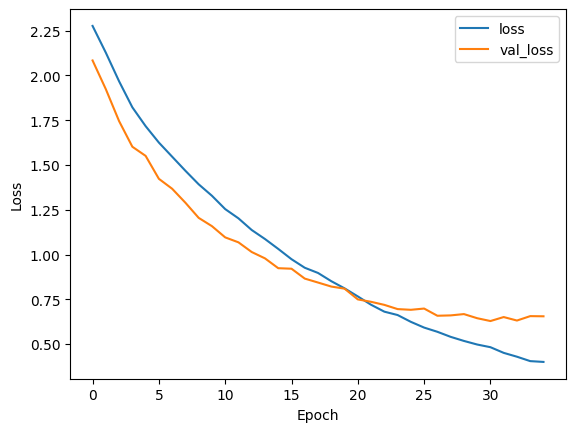

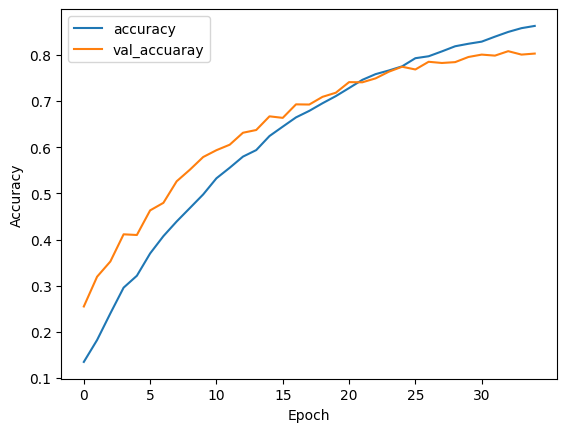

85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7729 - loss: 0.6652
Model evaulation [0.6337299346923828, 0.7862963080406189]
[array(0.63372993, dtype=float32), array(0.7862963, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
actual class of predicted: 1
predicted class 1
predicted probability 0.4671306908130646


In [5]:
#Model construction
model = ks.Sequential()

#input layers
model.add(ks.layers.Flatten(input_shape=(128, 128, 3)))

#hidden layers
model.add(ks.layers.Dense(2000,activation="relu"))
model.add(ks.layers.Dropout(0.5))

model.add(ks.layers.Dense(2000,activation="relu"))
model.add(ks.layers.Dropout(0.5))

model.add(ks.layers.Dense(2000,activation="relu"))
model.add(ks.layers.Dropout(0.5))

model.add(ks.layers.Dense(2000,activation="relu"))
model.add(ks.layers.Dropout(0.5))

#output layer
model.add(ks.layers.Dense(9,activation="softmax"))

#construction of optimizer >>> loss function ex.
opt = Adam(learning_rate=0.00001)
model.compile(optimizer=opt,loss="categorical_crossentropy",metrics=["accuracy"])

#model traning
results = model.fit(
    x_train, 
    y_train, 
    epochs=35, 
    validation_data=(x_val, y_val), 
    batch_size=16,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

#visualizing
plt.plot(results.history["loss"],label="loss")
plt.plot(results.history["val_loss"],label="val_loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(range(0,35,5))
plt.legend()
plt.show()

plt.plot(results.history["accuracy"],label="accuracy")
plt.plot(results.history["val_accuracy"],label="val_accuaray")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(range(0,35,5))
plt.legend()
plt.show()

#model evaulation
print(f"Model evaulation {model.evaluate(x_test,y_test)}")

#performance evulation
test_result = model.test_on_batch(x_test,y_test)
print(test_result)

#prediction of a data point
pred_result = model.predict(x_test[1001].reshape(1,128,128,3))

#actual value of a data point
print(f"actual class of predicted: {np.argmax(y_test[1001])}")

#finding the predicted class
predicted_class = pred_result.argmax()
print(f"predicted class {predicted_class}")

#finding the prediction probability
predicted_prob = pred_result.max()
print(f"predicted probability {predicted_prob}")